## Importing relevant libraries

In [ ]:
import random
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import sys
import shutil
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from sklearn.utils import compute_class_weight
from timeit import default_timer as timer
from torch import cuda
import glob


## Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

data_path = '/content/drive/MyDrive/archive_occular_disease/ODIR-5K/ODIR-5K'
training_images_file = '/content/drive/MyDrive/archive_occular_disease/ODIR-5K/ODIR-5K/TrainingImages'
testing_images_file = '/content/drive/MyDrive/archive_occular_disease/ODIR-5K/ODIR-5K/TestingImages'
labels_file = '/content/drive/MyDrive/archive_occular_disease/full_df.csv'
os.listdir(data_path)

['data.xlsx', 'TrainingImages', 'TestingImages']

## Exploring the dataset

In [ ]:
df_data = pd.read_csv("/content/drive/MyDrive/archive_occular_disease/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df_data.info() #getting an idea of our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [ ]:
df_data.C #printing the IDs of patients and whether they have cataract (label = 'C') or not

0       1
1       0
2       0
3       0
4       0
       ..
6387    0
6388    0
6389    0
6390    0
6391    0
Name: C, Length: 6392, dtype: int64

In [ ]:
len(df_data.N) #printing the number of people who have been tested for ocular diseases and whether they are normal or not
#(label = 'N'). The number should the same as the total number of IDs

6392

In [ ]:
df_data[df_data.M==1].head() #printing the list of patients who have Pathological Myopia (label = 'M')

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg
14,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",16_right.jpg
16,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",18_right.jpg
29,35,68,Female,35_left.jpg,35_right.jpg,pathological myopia,normal fundus,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",35_right.jpg
37,46,66,Male,46_left.jpg,46_right.jpg,moderate non proliferative retinopathy,pathological myopia,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",46_right.jpg


In [ ]:
images_path = '/content/drive/MyDrive/archive_occular_disease/preprocessed_images'

In [ ]:
occular_df = df_data[['ID','Patient Age','Patient Sex','Left-Fundus','Right-Fundus','Left-Diagnostic Keywords','Right-Diagnostic Keywords','labels','target','filename']].copy()
occular_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
occular_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   labels                     6392 non-null   object
 8   target                     6392 non-null   object
 9   filename                   6392 non-null   object
dtypes: int64(2), object(8)
memory usage: 499.5+ KB


In [ ]:
data = []
data = {'FilePaths' : [], 'Filename' : []}

for preprocessed_images in os.listdir(images_path):
    if preprocessed_images.endswith("jpg"):
        # Your code comes here such as
        file_path = os.path.abspath(preprocessed_images)
        #data.append(file_path)
        data['FilePaths'].append(file_path)
        data['Filename'].append(preprocessed_images)

In [ ]:
datadict = {}

for preprocessed_images in os.listdir(images_path):
    if preprocessed_images.endswith("jpg"):
        # Your code comes here such as
        file_path = os.path.abspath(preprocessed_images)
        #data.append(file_path)
        datadict[preprocessed_images]=file_path
        # data['FilePaths'].append(file_path)
        # data['Filename'].append(preprocessed_images)

# for i in range(len(keys)):
#     dictionary[keys[i]] = values[i]

In [ ]:
len(datadict)

6420

In [ ]:
data = []
data = {'FilePaths' : [], 'Filename' : []}

for preprocessed_images in os.listdir(images_path):
    if preprocessed_images.endswith("jpg"):
      for im in occular_df.filename:
        if preprocessed_images == im:
          file_path = os.path.abspath(preprocessed_images)
          occular_df['filepath'].append(file_path)
          # data.append(file_path)
          # data['FilePaths'].append(file_path)
          # data['Filename'].append(preprocessed_images)

KeyError: ignored

In [ ]:
data_df = pd.DataFrame(data)

data_df

,FilePaths,Filename
0,/content/471_right.jpg,471_right.jpg
1,/content/4689_right.jpg,4689_right.jpg
2,/content/476_left.jpg,476_left.jpg
3,/content/47_left.jpg,47_left.jpg
4,/content/483_left.jpg,483_left.jpg
...,...,...
6415,/content/1270_left.jpg,1270_left.jpg
6416,/content/127_right.jpg,127_right.jpg
6417,/content/1280_right.jpg,1280_right.jpg
6418,/content/1281_left.jpg,1281_left.jpg


In [ ]:
# Iterate over columns using DataFrame.iteritems()
for (filepath,colval) in occular_df.iteritems():
    colval.values =

In [ ]:
# Transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
        # Test does not use augmentation
    'test':
    transforms.Compose([
        # transforms.Resize(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Tensor visualisation
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

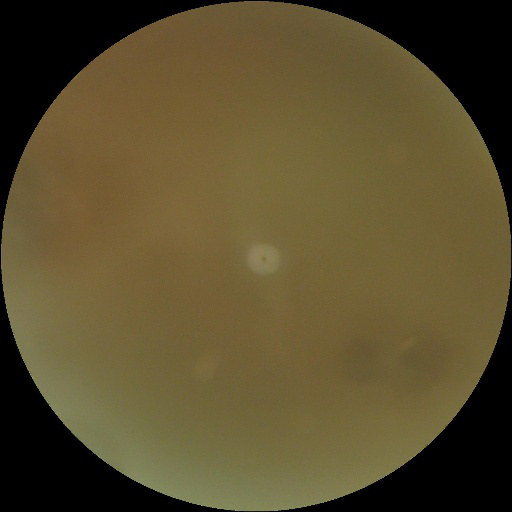

In [ ]:
Image.open(f'{images_path}/0_left.jpg')